In [6]:
import os
os.environ['DYLD_FALLBACK_LIBRARY_PATH'] = '/opt/homebrew/lib'
import openslide
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
import json
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import cv2
import shapely
from rasterio.features import rasterize
from openslide.deepzoom import DeepZoomGenerator
import itertools
import time
from Tile import *
import geopandas

In [7]:
import pickle
with open('tiles.pkl', 'rb') as f:
    tiles = pickle.load(f)

In [9]:
def to_grayscale_three_channels(img):
    img = img.transpose(1, 2, 0)
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    three_channel_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2BGR)
    return three_channel_img

for idx, tile in enumerate(tiles):
    tiles[idx].image_data = to_grayscale_three_channels(tile.image_data)

In [10]:
print(tiles[0].image_data.shape)
print(tiles[0].mask.shape)

(128, 128, 3)
(1, 128, 128)


In [11]:
tiles_with_masks = [t for t in tiles if 1 in t.mask]
import random
random.seed(42)
additional_samples = random.sample(tiles, 3 * len(tiles_with_masks))
combined_tiles = tiles_with_masks + additional_samples

In [12]:
tiles = []
masks = []
for img in combined_tiles:
    masks.append(img.mask)
    tiles.append(img.image_data)

In [25]:
for idx, mask in enumerate(masks):
    masks[idx] = mask.transpose(1,2,0)
# for idx, tile in enumerate(tiles):
#     tiles[idx] = tile.transpose(1,2,0)

In [27]:
for idx, tile in enumerate(tiles):
    tiles[idx] = np.mean(tile, axis=2, keepdims=True)

In [ ]:
device = torch.device('mps')

In [33]:
class UNet(nn.Module):
    """
    Base Unet Implementation
    """

    def __init__(self, n_class:int = 2) -> None:
        """
        Initialize Unet, n_class is number of classes we want to segment images for
        Defaults at 2 for 2 ROI types
        """
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        # In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image. 
        # Each block in the decoder consists of an upsampling layer, a concatenation with the corresponding encoder feature map, and two convolutional layers.
        # -------
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [34]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TiledWSIDataset(Dataset):
    def __init__(self, tiles, masks):
        self.tiles = tiles
        self.masks = masks
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])
        
    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        image = self.tiles[idx]
        mask = self.masks[idx]
        image = self.transform(image)
        mask = np.array(mask)
        mask = torch.tensor(mask)
        mask = mask.squeeze()
        return image, mask
dataset = TiledWSIDataset(tiles, masks)

In [35]:
from torch.optim import Adam

def criterion(pred, target):
    bce_loss = F.binary_cross_entropy_with_logits(pred, target.float())
    return bce_loss

model = UNet(n_class=1)
optimizer = Adam(model.parameters(), lr=0.001)

In [37]:
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
train_size = int(0.7 * len(dataset))  # 70% for training
remaining = len(dataset) - train_size
validation_size = int(0.15 * len(dataset))  # 15% for validation
test_size = remaining - validation_size  # 15% for testing

train_dataset, remaining_dataset = random_split(dataset, [train_size, remaining])
val_dataset, test_dataset = random_split(remaining_dataset, [validation_size, test_size])

# Data loaders for training, validation, and test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    model.to(device)
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for images, masks in tqdm(train_loader):
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images)
            masks = masks.unsqueeze(1)  # Ensure masks have the correct shape
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
                outputs = model(images)
                masks = masks.unsqueeze(1)
                loss = criterion(outputs, masks)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    return train_losses, val_losses

train_losses, val_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, epochs=20)

  0%|          | 0/316 [00:00<?, ?it/s]

100%|██████████| 316/316 [02:34<00:00,  2.04it/s]


Epoch 1, Training Loss: 0.013807837915644565, Validation Loss: 0.013924886920555588


100%|██████████| 316/316 [02:27<00:00,  2.15it/s]


Epoch 2, Training Loss: 0.013688399445939843, Validation Loss: 0.013796540907655506


100%|██████████| 316/316 [02:27<00:00,  2.15it/s]


Epoch 3, Training Loss: 0.013643265199413638, Validation Loss: 0.013752530321189902


100%|██████████| 316/316 [02:29<00:00,  2.12it/s]


Epoch 4, Training Loss: 0.013507801092402046, Validation Loss: 0.01368941397630607


100%|██████████| 316/316 [02:31<00:00,  2.08it/s]


Epoch 5, Training Loss: 0.013515318020750814, Validation Loss: 0.013656600855724304


100%|██████████| 316/316 [02:26<00:00,  2.15it/s]


Epoch 6, Training Loss: 0.013459116258795726, Validation Loss: 0.013738363073142941


100%|██████████| 316/316 [02:26<00:00,  2.15it/s]


Epoch 7, Training Loss: 0.013460256165201185, Validation Loss: 0.013612958911328214


100%|██████████| 316/316 [02:29<00:00,  2.12it/s]


Epoch 8, Training Loss: 0.013414283782155294, Validation Loss: 0.013561546032008261


100%|██████████| 316/316 [02:27<00:00,  2.14it/s]


Epoch 9, Training Loss: 0.013415547365250855, Validation Loss: 0.013600068436875348


100%|██████████| 316/316 [02:27<00:00,  2.14it/s]


Epoch 10, Training Loss: 0.013460760636570191, Validation Loss: 0.013520378966851028


100%|██████████| 316/316 [02:27<00:00,  2.14it/s]


Epoch 11, Training Loss: 0.013402455311146972, Validation Loss: 0.013482343966170582


100%|██████████| 316/316 [02:26<00:00,  2.15it/s]


Epoch 12, Training Loss: 0.0133549300045453, Validation Loss: 0.01351068589220637


100%|██████████| 316/316 [02:26<00:00,  2.15it/s]


Epoch 13, Training Loss: 0.013259056453711908, Validation Loss: 0.01351493847447199


100%|██████████| 316/316 [02:27<00:00,  2.15it/s]


Epoch 14, Training Loss: 0.013307378817677617, Validation Loss: 0.013479602379536914


100%|██████████| 316/316 [02:27<00:00,  2.15it/s]


Epoch 15, Training Loss: 0.013238329803672436, Validation Loss: 0.014071546997169818


100%|██████████| 316/316 [02:26<00:00,  2.15it/s]


Epoch 16, Training Loss: 0.01325139785378906, Validation Loss: 0.013420414320594827


100%|██████████| 316/316 [02:27<00:00,  2.15it/s]


Epoch 17, Training Loss: 0.01318507564321352, Validation Loss: 0.01348350027151275


100%|██████████| 316/316 [02:26<00:00,  2.15it/s]


Epoch 18, Training Loss: 0.01315912164961431, Validation Loss: 0.013309870895586516


100%|██████████| 316/316 [02:26<00:00,  2.16it/s]


Epoch 19, Training Loss: 0.013160468707216717, Validation Loss: 0.01345049096606775


100%|██████████| 316/316 [02:26<00:00,  2.16it/s]


Epoch 20, Training Loss: 0.013224535744220873, Validation Loss: 0.013418492566130279


**Test set Evaluation**

In [38]:
def evaluate_on_test(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            masks = masks.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f'Average Test Loss: {avg_test_loss}')

evaluate_on_test(model, test_loader, device)

100%|██████████| 68/68 [00:09<00:00,  7.24it/s]

Average Test Loss: 0.013356825976024255


**Metric Evaluation**

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [40]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32).unsqueeze(1)  
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  
        
            preds = preds.int()
            
            masks = masks.int()
            all_predictions.extend(preds.view(-1).cpu().numpy())
            all_targets.extend(masks.view(-1).cpu().numpy())

    
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Accuracy: 0.7908685550478551, Precision: 0.5158637245848772, Recall: 0.212858356773406, F1 Score: 0.3013656578910739


**Confusion matrix**

In [59]:
def compute_confusion_matrix(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32).unsqueeze(1)  # Ensure the correct shape
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Apply threshold to get binary predictions
            
            preds = preds.int()
            
            masks = masks.int()
            all_predictions.extend(preds.view(-1).cpu().numpy())
            all_targets.extend(masks.view(-1).cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    return cm

# Compute confusion matrix
conf_matrix = compute_confusion_matrix(model, test_loader, device)
print(conf_matrix)


100%|██████████| 68/68 [00:09<00:00,  7.17it/s]


[[6622468  375911]
 [1481203  400546]]


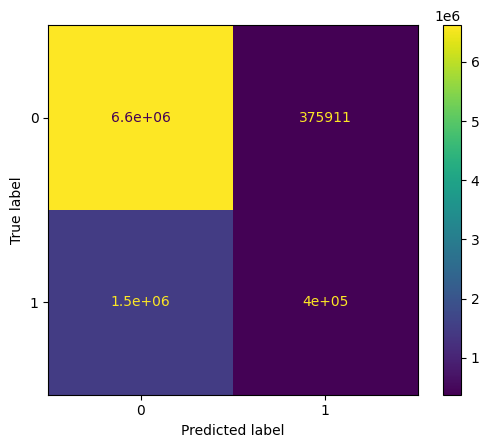

In [60]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

**TEST**

In [86]:
import matplotlib.pyplot as plt
import torch

def get_predictions(model, dataloader, device):
    model.eval()
    images, masks = next(iter(dataloader))  # Get one batch of data
    images = images.to(device, dtype=torch.float32)
    masks = masks.unsqueeze(1).to(device, dtype=torch.float32)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
        preds = preds.float()  

    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    return images, masks, preds

images, true_masks, predicted_masks = get_predictions(model, test_loader, device)

**Training**

In [89]:
import matplotlib.pyplot as plt
import torch

def get_predictions(model, dataloader, device):
    model.eval()
    images, masks = next(iter(dataloader))  # Get one batch of data
    images = images.to(device, dtype=torch.float32)
    masks = masks.unsqueeze(1).to(device, dtype=torch.float32)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
        preds = preds.float()  

    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    return images, masks, preds

images, true_masks, predicted_masks = get_predictions(model, val_loader, device)

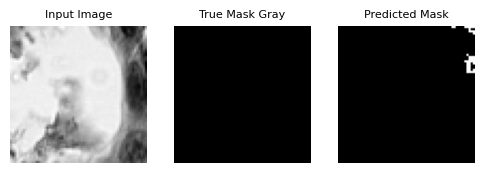

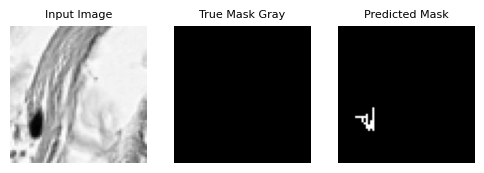

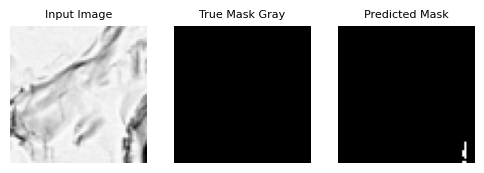

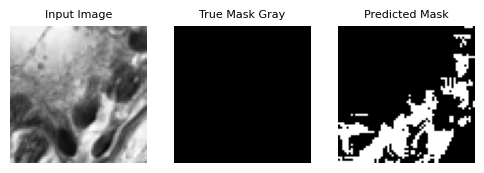

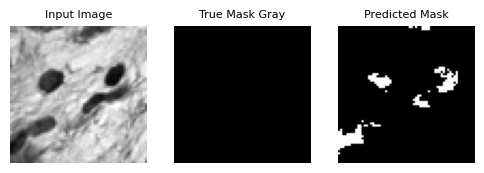

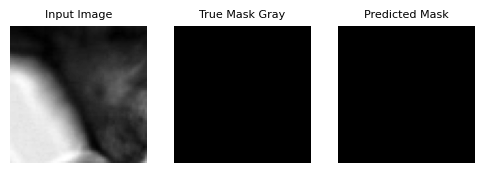

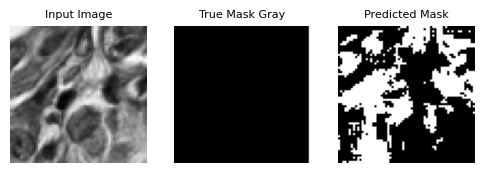

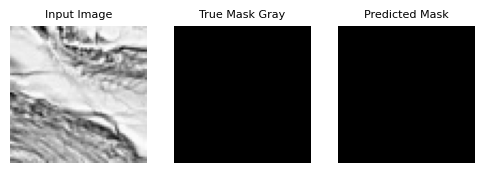

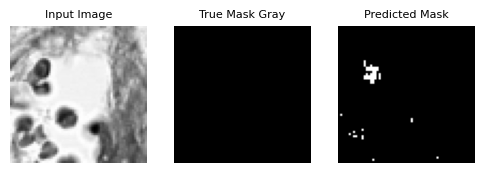

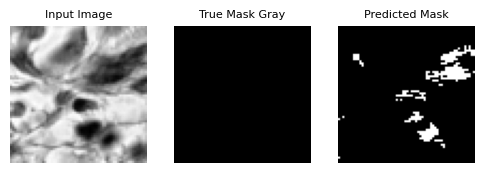

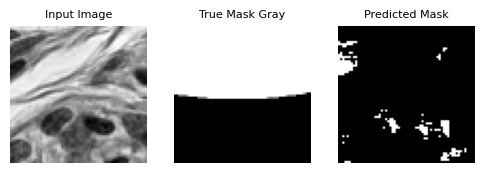

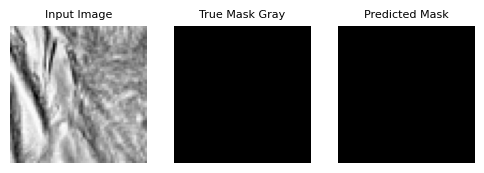

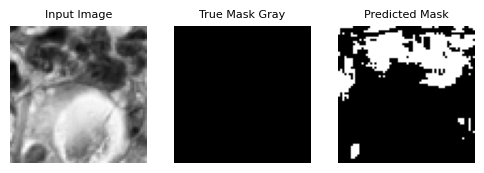

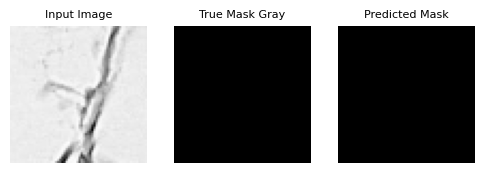

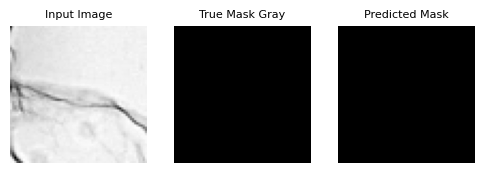

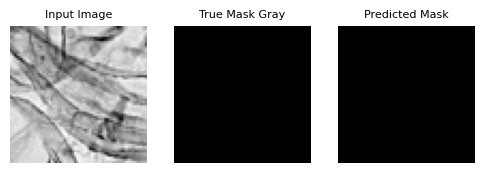

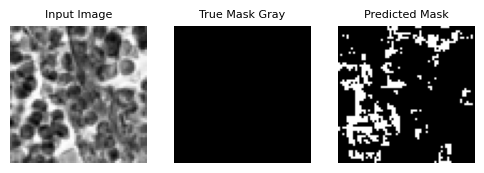

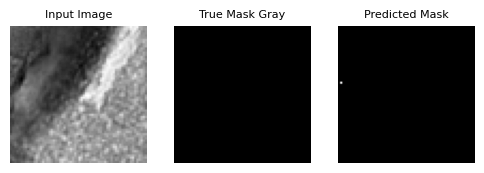

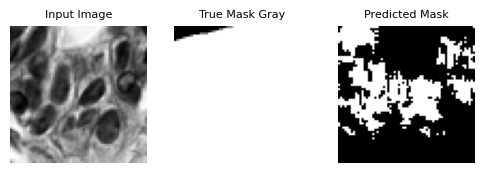

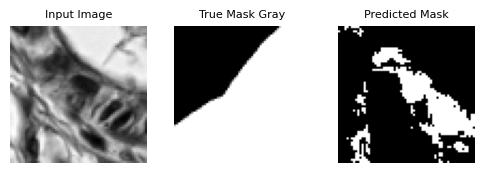

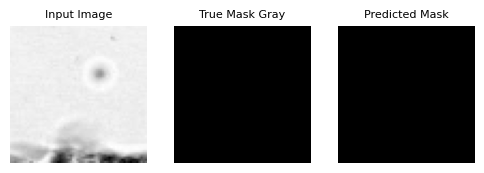

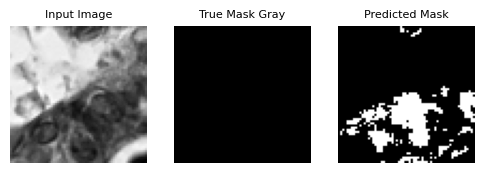

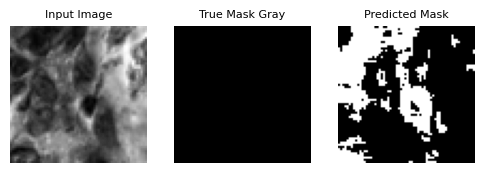

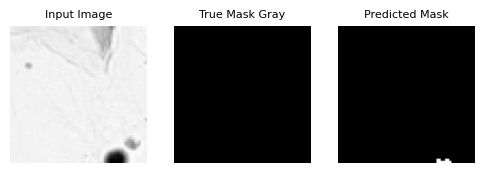

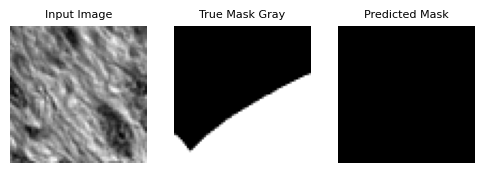

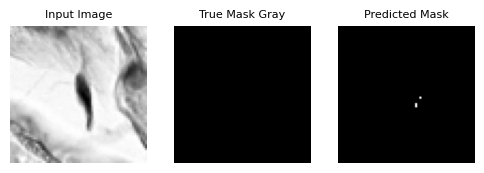

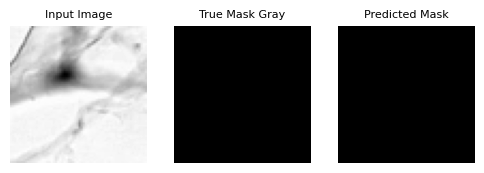

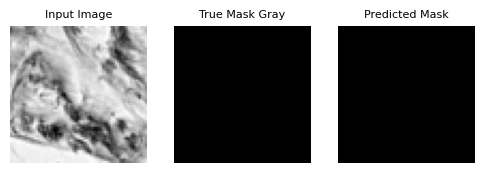

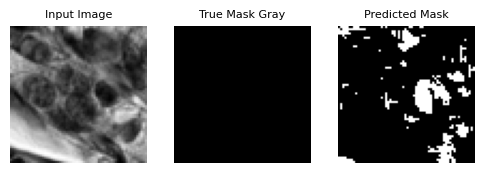

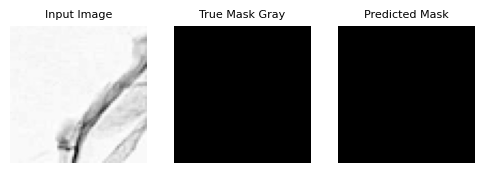

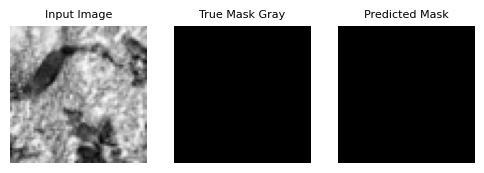

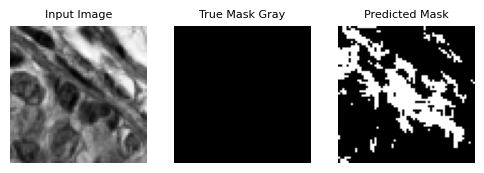

In [90]:
num_images = len(images)
for idx in range(32):
    fig, ax = plt.subplots(1, 3,figsize=(6,4))
    ax[0].imshow(images[idx].permute(1, 2, 0), cmap='gray') 
    ax[0].set_title('Input Image', fontsize=8)
    ax[0].axis('off')
    
    ax[1].imshow(true_masks[idx].squeeze(), cmap='gray')
    ax[1].set_title('True Mask Gray', fontsize=8)
    ax[1].axis('off')

    ax[2].imshow(predicted_masks[idx].squeeze(), cmap='gray')
    ax[2].set_title('Predicted Mask', fontsize=8)
    ax[2].axis('off')
    plt.show()